Optimal control using Koopman Model

As is now

In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

import src.models as models
import src.helper as helper
%load_ext autoreload
%autoreload 2

Models imported succesfully
Helper imported succesfully


Load matrices, model, scalers and load process

In [2]:
matrix_C = False

# Load matrices A, B, and C 
A = np.load('./data/A_C_' + str(matrix_C) + '.npy')
B = np.load('./data/B_C_' + str(matrix_C) + '.npy')
C = np.load('./data/C_C_' + str(matrix_C) + '.npy')

nz, nu = B.shape  # state and input dimensions
ny = C.shape[0]  # output dimensions

In [3]:
# model parameters

layers = [20,40,60]
layers_dec  = [60,40,20]


In [4]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

# no loss function because only using the model not training it
loss = PenaltyLoss([], constraints=[])

problem = Problem(nodes, loss)

problem.load_state_dict(torch.load('data/model_C_' + str(matrix_C) + '.pth'),strict=False)



<All keys matched successfully>

In [5]:
# load scalers
scaler = joblib.load('data/scaler.pkl')
scalerU = joblib.load('data/scalerU.pkl')

In [6]:
# define same model as for training
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

Necesary?

In [7]:
# probably yes
def get_x(y):
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1,-1).T

def get_y(x):
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1,-1)

## normal MPC using C


In [ ]:

# Simulation parameters
T = 20  # number of steps
z_true = np.zeros((nz, T+1))
z_est = np.zeros((nz, T+1))
y_meas = np.zeros((ny, T))
u_seq = np.ones((nu, T))  # constant ones input

# Initial state and covariance
z_true[:, 0] = get_x(np.zeros(2)).T
z_est[:, 0] = get_x(np.zeros(2)).T
P0 = np.eye(nz) * 0.1

# Noise covariances
Q = np.eye(nz) * 0.01  # process noise
R = np.eye(ny) * 0.05  # measurement noise

EKF = helper.KF(A,B,C,z_est[:, 0],P0, Q, R)

# # If you want to see resultra od simulate and apply EKF, uncomment the following code:
# for k in range(T):
#     # --- Simulate true system ---
#     #w_k = np.random.multivariate_normal(np.zeros(nz), Q)
#     x_true[:, k+1] = A @ x_true[:, k] + B @ u_seq[:, k] #+ w_k

#     # --- Generate noisy measurement ---
#     v_k = np.random.multivariate_normal(np.zeros(ny), R)
#     y_meas[:, k] = get_y(x_true[:, k+1]) + v_k

#     x_est[:, k+1] = EKF.step(u_seq[:, k], y_meas[:, k]).flatten()
    
# def plot_states(true_states, est_states, title="State estimates vs true values"):
#     nx, T_plus_1 = true_states.shape
#     T = T_plus_1 - 1
#     time = np.arange(T_plus_1)
    
#     plt.figure(figsize=(14, 2.5 * nx))
#     for i in range(nx):
#         plt.subplot(nx, 1, i + 1)
#         plt.plot(time, true_states[i], label=f"True x[{i}]")
#         plt.plot(time, est_states[i], label=f"Estimated x[{i}]", linestyle="--")
#         plt.title(f"State x[{i}]")
#         plt.xlabel("Time step")
#         plt.legend()
#         plt.grid(True)
#     plt.tight_layout()
#     plt.suptitle(title, fontsize=16, y=1.02)
#     plt.show()

# plot_states(x_true, x_est)


Parameters to construct MPC problem reference tracking using C

In [ ]:
N = 20
Qy = np.eye(ny)*20
Qu = np.eye(nu)

# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
y0 = cp.Parameter(ny)
u_prev = cp.Parameter(nu)
y_ref = cp.Parameter(ny)

# Decision variables
z = cp.Variable((nz, N+1))
y = cp.Variable((ny, N))
delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N + 1)) 

In [ ]:

# Constraints and cost
constraints = [z[:, 0] == z0]
constraints += [u[:, 0] == u_prev + delta_u[:, 0]]
cost = 0
for k in range(N):
    constraints += [u[:, k] == u[:, k-1] + delta_u[:, k]]
    
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        y[:, k] == C @ z[:, k],
        u_min <= u[:, k], u[:, k] <= u_max,
        y_min <= y[:, k], y[:, k] <= y_max
    ]
    
    cost += cp.quad_form(y[:, k] - y_ref, Qy) + cp.quad_form(delta_u[:, k], Qu)

# Terminal cost - not yet
# cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [ ]:
y0.value = scaler.transform(np.array([[0.5 , 0.3]]))[0]
z0.value = get_x(y0.value).T[0]
u_prev.value = scalerU.transform(np.array([[0.1, 0.1]]))[0]
y_ref.value = scaler.transform(np.array([[1, 1]]))[0]

In [ ]:
# target estimation
z_s = cp.Variable(nz)
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)

# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C @ z_s]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_ref, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimanl value:", target_estimation.value)
print("Optimal u:", u_s.value)
print("Optimal y:", y_s.value)
print("Optimal z:", z_s.value)
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))

y_ref.value = y_s.value
z_ref_store = z_s.value

optimal
Optimanl value: 1.2691291261077066e-18
Optimal u: [-0.97079077  0.63711121]
Optimal y: [-0.25787823  0.05853135]
Optimal z: [-0.25606938 -0.34204551  0.07346435  0.46208751  0.00961057  0.57806848
  0.01480864  0.03828539 -0.27581379 -0.36402591]
Optimal u: [[0.07559511 0.68489824]]
Optimal y: [[1. 1.]]


In [ ]:
# sanity check
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[0.29715642 0.59873646]
optimal


In [ ]:
# Observer initialization

P0 = np.eye(nz) * 0.1 # initial covariance
Q = np.eye(nz) * 0.01  # process noise
R = np.eye(ny) * 0.05  # measurement noise

EKF = helper.EKF_test(A,B,z0.value,P0,problem, Q, R, False, None, C)

Simulation

In [ ]:
sim_time = 100
Ts = 1
z_sim = np.zeros((nz, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))

z_sim[:, 0] = z0.value
y_sim[:, 0] = y0.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y0.value.reshape(1,-1))[0]


for k in range(sim_time):
    # solve MPC
    mpc.solve(solver=cp.GUROBI)
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = EKF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    y0.value = y_sim[:, k+1]
    z0.value = z_sim[:, k+1]
    u_prev.value = u_sim[:, k]
    print(k)
    print(mpc.status)
    

0
optimal
1
optimal
2
optimal
3
optimal
4
optimal
5
optimal
6
optimal
7
optimal
8
optimal
9
optimal
10
optimal
11
optimal
12
optimal
13
optimal
14
optimal
15
optimal
16
optimal
17
optimal
18
optimal
19
optimal
20
optimal
21
optimal
22
optimal
23
optimal
24
optimal
25
optimal
26
optimal
27
optimal
28
optimal
29
optimal
30
optimal
31
optimal
32
optimal
33
optimal
34
optimal
35
optimal
36
optimal
37
optimal
38
optimal
39
optimal
40
optimal
41
optimal
42
optimal
43
optimal
44
optimal
45
optimal
46
optimal
47
optimal
48
optimal
49
optimal
50
optimal
51
optimal
52
optimal
53
optimal
54
optimal
55
optimal
56
optimal
57
optimal
58
optimal
59
optimal
60
optimal
61
optimal
62
optimal
63
optimal
64
optimal
65
optimal
66
optimal
67
optimal
68
optimal
69
optimal
70
optimal
71
optimal
72
optimal
73
optimal
74
optimal
75
optimal
76
optimal
77
optimal
78
optimal
79
optimal
80
optimal
81
optimal
82
optimal
83
optimal
84
optimal
85
optimal
86
optimal
87
optimal
88
optimal
89
optimal
90
optimal
91
optima

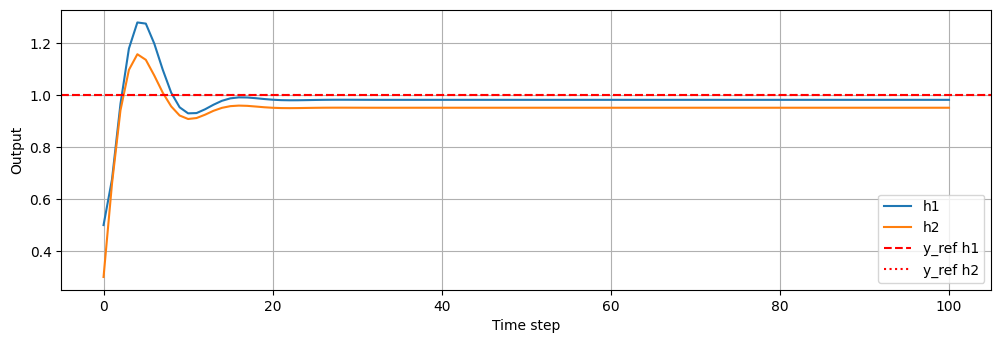

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0], label='h1')
plt.plot(y_sim_descaled[1], label='h2')
plt.axhline(y=scaler.inverse_transform(y_ref.value.reshape(1, -1))[0][0], color='red', linestyle='--', label='y_ref h1')
plt.axhline(y=scaler.inverse_transform(y_ref.value.reshape(1, -1))[0][1], color='red', linestyle=':', label='y_ref h2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

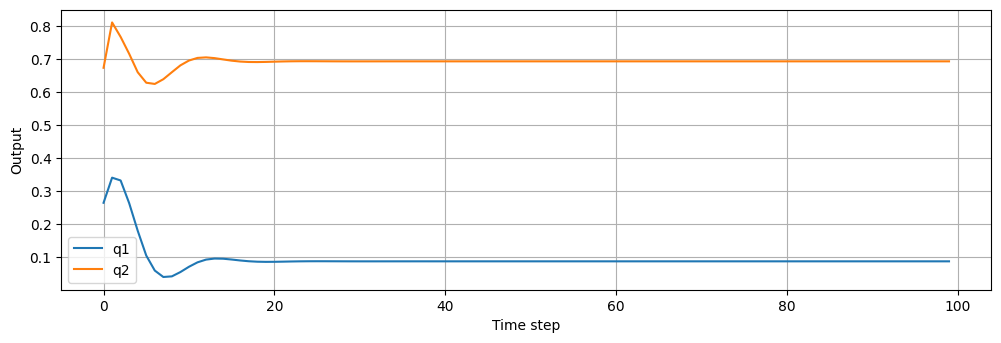

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0], label='q1')
plt.plot(u_sim_descaled[1], label='q2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

## Without Directly using matrix C (only for obtaining matrix)


In [ ]:
# target estimation
z_s = cp.Variable(nz)
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)

# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C @ z_s]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_ref, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimanl value:", target_estimation.value)
print("Optimal u:", u_s.value)
print("Optimal y:", y_s.value)
print("Optimal z:", z_s.value)
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))

y_ref.value = y_s.value
z_ref_store = z_s.value

optimal
Optimanl value: 1.2691503287689487e-18
Optimal u: [-0.97079076  0.6371112 ]
Optimal y: [-0.25787822  0.05853135]
Optimal z: [-0.25606937 -0.34204551  0.07346435  0.46208751  0.00961057  0.57806848
  0.01480864  0.03828539 -0.27581379 -0.36402591]
Optimal u: [[0.07559512 0.68489824]]
Optimal y: [[1. 1.]]


In [ ]:
np.float32(z_ref_store)[0].dtype

dtype('float32')

In [ ]:
z_est = get_x(y_s.value).T[0]
z_s = torch.nn.Parameter(torch.tensor(np.float32(z_ref_store)),requires_grad=True)
optimizer = torch.optim.Adam([z_s], lr=1e-2)
y_sp = torch.tensor(y_s.value, dtype=torch.float32, device=z_s.device)

In [ ]:
# z_s estimation using gradient descent
z_ref = cp.Parameter(nz)
for i in range(100):
    optimizer.zero_grad()
    y_pred = problem.nodes[4]({"x": z_s})["yhat"]
    loss = ((y_pred - y_sp)**2).sum()
    loss.backward()
    optimizer.step()

z_ref.value = z_s.detach().numpy()
#z_ref.value = z_ref_store

In [ ]:
z_s

Parameter containing:
tensor([-0.2372, -0.3455,  0.1043,  0.4272,  0.0430,  0.6035, -0.0019,  0.0077,
        -0.2461, -0.3980], requires_grad=True)

In [ ]:
z_ref_store

array([-0.25606937, -0.34204551,  0.07346435,  0.46208751,  0.00961057,
        0.57806848,  0.01480864,  0.03828539, -0.27581379, -0.36402591])

In [ ]:
N = 20
#Jh = helper.evaluate_jacobian(problem.nodes[4], z_s)
Jh = helper.evaluate_jacobian(problem.nodes[4], torch.tensor(z_ref_store))
Qz = Jh.T@np.eye(ny)*20@Jh
Qz = C.T@np.eye(ny)*20@C
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
Qu = np.eye(nu)

# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
# y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
# y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
y0 = cp.Parameter(ny)
u_prev = cp.Parameter(nu)


# Decision variables
z = cp.Variable((nz, N+1))
#y = cp.Variable((ny, N))
delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N + 1)) 

In [ ]:
# Ensure PSD
eigvals = np.linalg.eigvalsh(Qz_psd)
print("Min eigenvalue of P:", eigvals.min())
assert np.all(eigvals >= -1e-8), "Matrix P must be positive semidefinite"

Min eigenvalue of P: 9.999963075464137e-09


In [ ]:

# Constraints and cost
constraints = [z[:, 0] == z0]
constraints += [u[:, 0] == u_prev + delta_u[:, 0]]
cost = 0
for k in range(N):
    constraints += [u[:, k] == u[:, k-1] + delta_u[:, k]]
    
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        u_min <= u[:, k], u[:, k] <= u_max,
        #y_min <= y[:, k], y[:, k] <= y_max
    ]
    
    cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(delta_u[:, k], Qu)

# Terminal cost - not yet
# cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [ ]:
y0.value = scaler.transform(np.array([[0.5 , 0.3]]))[0]
z0.value = get_x(y0.value).T[0]
u_prev.value = scalerU.transform(np.array([[0.1, 0.1]]))[0]
y_sp = scaler.transform(np.array([[1, 1]]))[0]

In [ ]:
# target estimation
z_s = cp.Variable(nz)
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)

# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C @ z_s]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_ref, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimanl value:", target_estimation.value)
print("Optimal u:", u_s.value)
print("Optimal y:", y_s.value)
print("Optimal z:", z_s.value)
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))

y_ref.value = y_s.value
z_ref_store = z_s.value

optimal
Optimanl value: 1.2692279010910616e-18
Optimal u: [-0.97079076  0.6371112 ]
Optimal y: [-0.25787822  0.05853135]
Optimal z: [-0.25606937 -0.34204551  0.07346435  0.46208751  0.00961057  0.57806848
  0.01480864  0.03828539 -0.27581379 -0.36402591]
Optimal u: [[0.07559512 0.68489824]]
Optimal y: [[1. 1.]]


In [ ]:
scaler.inverse_transform(y_sp.reshape(1, -1))

array([[1., 1.]])

In [ ]:
type(z_s.value)
type(get_x(y_sp).T[0])

numpy.ndarray

In [ ]:
z_est = get_x(y_sp).T[0]
z_s = torch.nn.Parameter(torch.tensor(np.float32(z_ref_store)),requires_grad=True)
optimizer = torch.optim.Adam([z_s], lr=1e-2)
y_sp = torch.tensor(y_sp, dtype=torch.float32, device=z_s.device)

In [ ]:
# z_s estimation using gradient descent

for i in range(100):
    optimizer.zero_grad()
    y_pred = problem.nodes[4]({"x": z_s})["yhat"]
    loss = ((y_pred - y_sp)**2).sum()
    loss.backward()
    optimizer.step()

z_ref.value = z_s.detach().numpy()
z_ref.value = z_ref_store

In [ ]:
# array([ 0.07729723, -0.08411676,  0.06028246,  0.11647341,  0.04078661,
#         0.21180393, -0.01650743,  0.01489813,  0.01994653, -0.05512307],
#       dtype=float32)

In [ ]:
#z_ref.value = z_s.detach().numpy()

In [ ]:
z_ref.value

array([-0.25606937, -0.34204551,  0.07346435,  0.46208751,  0.00961057,
        0.57806848,  0.01480864,  0.03828539, -0.27581379, -0.36402591])

In [ ]:
# sanity check
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[0.29715641 0.59873648]
optimal


In [ ]:
# Observer initialization

P0 = np.eye(nz) * 0.1 # initial covariance
Q = np.eye(nz) * 0.01  # process noise
R = np.eye(ny) * 0.05  # measurement noise

EKF = helper.EKF_test(A,B,z0.value,P0,problem, Q, R, False, None, C)

In [ ]:
z_ref.value

array([-0.25606937, -0.34204551,  0.07346435,  0.46208751,  0.00961057,
        0.57806848,  0.01480864,  0.03828539, -0.27581379, -0.36402591])

In [ ]:
sim_time = 100
Ts = 1
z_sim = np.zeros((nz, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))

z_sim[:, 0] = z0.value
y_sim[:, 0] = y0.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y0.value.reshape(1,-1))[0]


for k in range(sim_time):
    # solve MPC
    mpc.solve(solver=cp.GUROBI)
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = EKF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    y0.value = y_sim[:, k+1]
    z0.value = z_sim[:, k+1]
    u_prev.value = u_sim[:, k]
    print(k)
    print(mpc.status)
    

0
optimal
1
optimal
2
optimal
3
optimal
4
optimal
5
optimal
6
optimal
7
optimal
8
optimal
9
optimal
10
optimal
11
optimal
12
optimal
13
optimal
14
optimal
15
optimal
16
optimal
17
optimal
18
optimal
19
optimal
20
optimal
21
optimal
22
optimal
23
optimal
24
optimal
25
optimal
26
optimal
27
optimal
28
optimal
29
optimal
30
optimal
31
optimal
32
optimal
33
optimal
34
optimal
35
optimal
36
optimal
37
optimal
38
optimal
39
optimal
40
optimal
41
optimal
42
optimal
43
optimal
44
optimal
45
optimal
46
optimal
47
optimal
48
optimal
49
optimal
50
optimal
51
optimal
52
optimal
53
optimal
54
optimal
55
optimal
56
optimal
57
optimal
58
optimal
59
optimal
60
optimal
61
optimal
62
optimal
63
optimal
64
optimal
65
optimal
66
optimal
67
optimal
68
optimal
69
optimal
70
optimal
71
optimal
72
optimal
73
optimal
74
optimal
75
optimal
76
optimal
77
optimal
78
optimal
79
optimal
80
optimal
81
optimal
82
optimal
83
optimal
84
optimal
85
optimal
86
optimal
87
optimal
88
optimal
89
optimal
90
optimal
91
optima

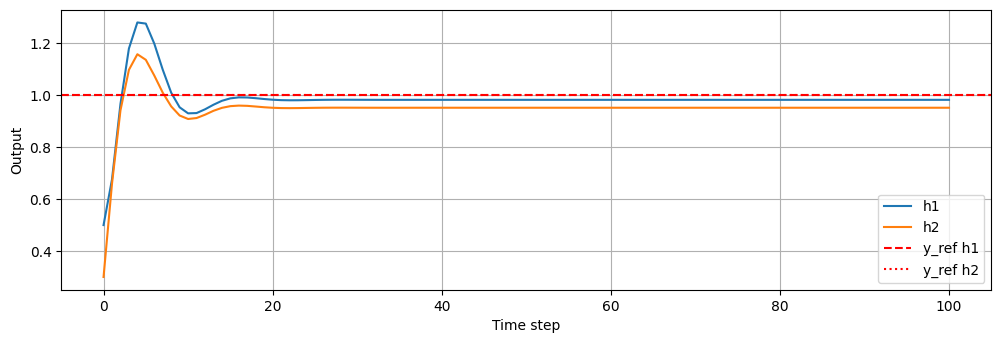

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0], label='h1')
plt.plot(y_sim_descaled[1], label='h2')
# plot reference as line
plt.axhline(y=scaler.inverse_transform(y_sp.reshape(1, -1))[0][0], color='red', linestyle='--', label='y_ref h1')
plt.axhline(y=scaler.inverse_transform(y_sp.reshape(1, -1))[0][1], color='red', linestyle=':', label='y_ref h2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

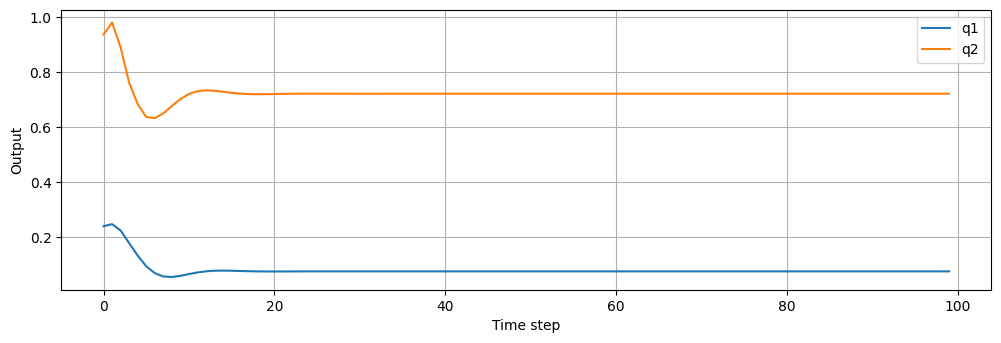

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0], label='q1')
plt.plot(u_sim_descaled[1], label='q2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

## W observer of a disturbance y_ref


In [ ]:
# "enhanced" matrices
F = np.eye(ny)
nd = F.shape[1]

Ae =  np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)]])

Be = np.vstack([
    B,
    np.zeros((nd, nu))])

Ce = np.hstack([C, F])

In [ ]:
N = 20
Qy = np.eye(ny)*20
Qu = np.eye(nu)

# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
y0 = cp.Parameter(ny)
d0 = cp.Parameter(nd)
u_prev = cp.Parameter(nu)
y_ref = cp.Parameter(ny)
y_sp = cp.Parameter(ny)

# Decision variables
z = cp.Variable((nz, N+1))
y = cp.Variable((ny, N))
delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N + 1)) 

In [ ]:

# Constraints and cost
constraints = [z[:, 0] == z0]
constraints += [u[:, 0] == u_prev + delta_u[:, 0]]
cost = 0
for k in range(N):
    constraints += [u[:, k] == u[:, k-1] + delta_u[:, k]]
    
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        y[:, k] == C @ z[:, k] + F @ d0,
        u_min <= u[:, k], u[:, k] <= u_max,
        y_min <= y[:, k], y[:, k] <= y_max
    ]
    
    cost += cp.quad_form(y[:, k] - y_ref, Qy) + cp.quad_form(delta_u[:, k], Qu)

# Terminal cost - not yet
# cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [ ]:
y0.value = scaler.transform(np.array([[0.5 , 0.3]]))[0]
z0.value = get_x(y0.value).T[0]
d0.value = np.zeros(nd)
u_prev.value = scalerU.transform(np.array([[0.1, 0.1]]))[0]
y_ref.value = scaler.transform(np.array([[1, 1]]))[0]
y_sp.value = scaler.transform(np.array([[1, 1]]))[0]

In [ ]:
# target estimation
z_s = cp.Variable(nz)
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)

# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C @ z_s + F @ d0]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_sp, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimanl value:", target_estimation.value)
print("Optimal u:", u_s.value)
print("Optimal y:", y_s.value)
print("Optimal z:", z_s.value)
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))

y_ref.value = y_s.value
z_ref_store = z_s.value

optimal
Optimanl value: 1.2691291261077066e-18
Optimal u: [-0.97079077  0.63711121]
Optimal y: [-0.25787823  0.05853135]
Optimal z: [-0.25606938 -0.34204551  0.07346435  0.46208751  0.00961057  0.57806848
  0.01480864  0.03828539 -0.27581379 -0.36402591]
Optimal u: [[0.07559511 0.68489824]]
Optimal y: [[1. 1.]]


In [ ]:
# sanity check
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[0.29715642 0.59873646]
optimal


In [ ]:
# Observer initialization

P0 = np.eye(nz+nd) * 0.1 # initial covariance
Q = np.eye(nz+nd) * 0.01  # process noise
R = np.eye(ny) * 0.05  # measurement noise
z0_obs = np.concatenate((z0.value, d0.value))

EKF = helper.EKF_test(A, B, z0_obs, P0, problem, Q, R, True, F, C)

Simulation

In [ ]:
sim_time = 100
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))


z_sim[:, 0] = z0_obs
y_sim[:, 0] = y0.value
ys_sim[:, 0] = y_s.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y0.value.reshape(1,-1))[0]


for k in range(sim_time):
    # solve MPC
    mpc.solve(solver=cp.GUROBI)
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = EKF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    y0.value = y_sim[:, k+1]
    z0.value = z_sim[:nz, k+1]
    d0.value = z_sim[nz:, k+1]
    target_estimation.solve(solver=cp.GUROBI)
    ys_sim[:, k+1] = y_s.value
    y_ref.value = y_s.value
    u_prev.value = u_sim[:, k]
    print(mpc.status)
    

optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal


In [ ]:
d0.value = z_sim[nz:, k+1]

In [ ]:
z_s.value 

array([-0.2939861 , -0.44902524,  0.12443453,  0.6796588 ,  0.08246939,
        0.73118051, -0.00548554,  0.09329889, -0.32152377, -0.53837347])

In [ ]:
target_estimation.solve(solver=cp.GUROBI)
y_s.value

array([-0.25787823,  0.05853135])

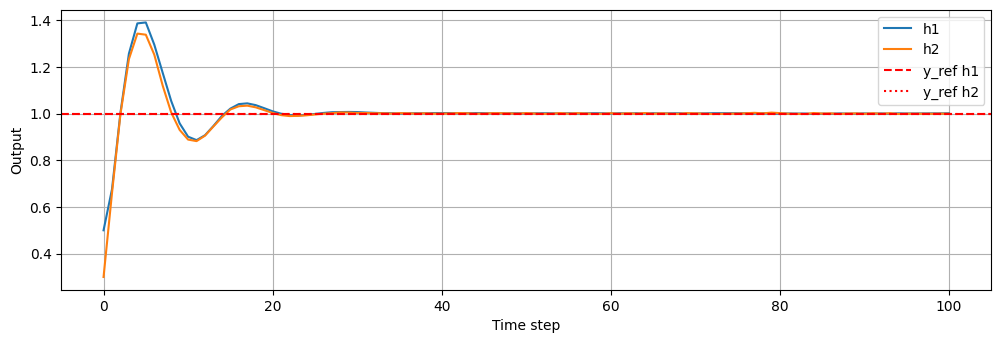

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0], label='h1')
plt.plot(y_sim_descaled[1], label='h2')
plt.axhline(y=scaler.inverse_transform(y_ref.value.reshape(1, -1))[0][0], color='red', linestyle='--', label='y_ref h1')
plt.axhline(y=scaler.inverse_transform(y_ref.value.reshape(1, -1))[0][1], color='red', linestyle=':', label='y_ref h2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

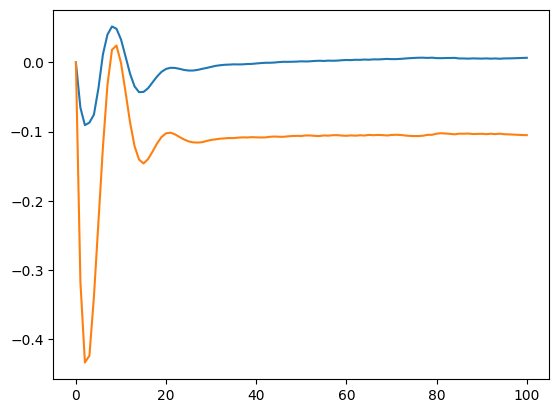

In [ ]:
plt.plot(z_sim[nz:, :].T)

In [ ]:
d0.value

array([ 0.00674101, -0.10502321])

In [ ]:
target_estimation.solve(solver=cp.GUROBI)

4.145191148386192e-20

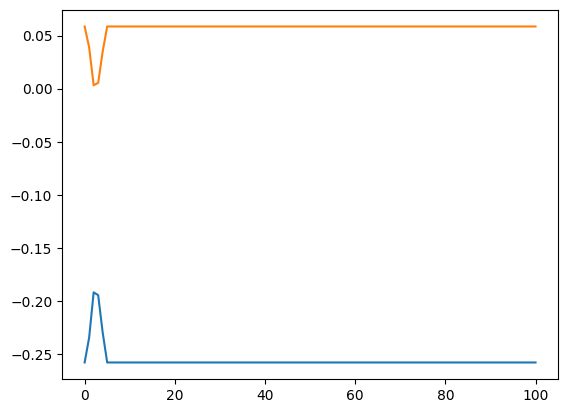

In [ ]:
plt.plot(ys_sim[0], label='h1')
plt.plot(ys_sim[1], label='h2')

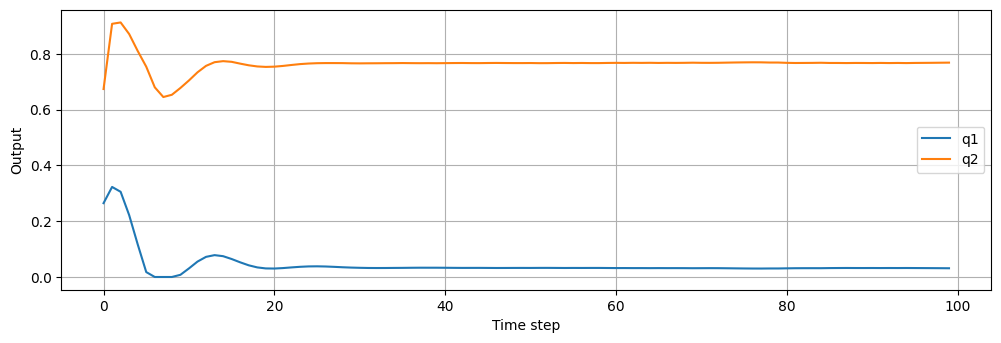

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0], label='q1')
plt.plot(u_sim_descaled[1], label='q2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

In [ ]:
y_s.value

array([-0.25787823,  0.05853135])

In [ ]:
y_sim[:, -1]

array([-0.25650841,  0.05720359])

## W observer of a disturbance and z_ref from target est


In [ ]:
# "enhanced" matrices
F = np.eye(ny)
nd = F.shape[1]

In [ ]:
# target estimation
z_s = cp.Variable(nz)
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)
d0.value = [0, 0]
# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C @ z_s + F @ d0]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_sp, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimanl value:", target_estimation.value)
print("Optimal u:", u_s.value)
print("Optimal y:", y_s.value)
print("Optimal z:", z_s.value)
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))

y_ref.value = y_s.value
z_ref.value = z_s.value

optimal
Optimanl value: 1.2691291261077066e-18
Optimal u: [-0.97079077  0.63711121]
Optimal y: [-0.25787823  0.05853135]
Optimal z: [-0.25606938 -0.34204551  0.07346435  0.46208751  0.00961057  0.57806848
  0.01480864  0.03828539 -0.27581379 -0.36402591]
Optimal u: [[0.07559511 0.68489824]]
Optimal y: [[1. 1.]]


In [ ]:
d0.value

array([0., 0.])

In [ ]:
Jh = helper.evaluate_jacobian(problem.nodes[4], torch.tensor(z_s.value))

In [ ]:
N = 20
Qz = Jh.T@np.eye(ny)*20@Jh
#Qz = C.T@np.eye(ny)*20@C
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
Qu = np.eye(nu)

# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
y0 = cp.Parameter(ny)
#d0 = cp.Parameter(nd)

u_prev = cp.Parameter(nu)
y_ref = cp.Parameter(ny)
y_sp = cp.Parameter(ny)
z_ref = cp.Parameter(nz)

# Decision variables
z = cp.Variable((nz, N+1))
y = cp.Variable((ny, N))
delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N + 1)) 

In [ ]:

# Constraints and cost
constraints = [z[:, 0] == z0]
constraints += [u[:, 0] == u_prev + delta_u[:, 0]]
cost = 0
for k in range(N):
    constraints += [u[:, k] == u[:, k-1] + delta_u[:, k]]
    
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        y[:, k] == C @ z[:, k] + F @ d0,
        u_min <= u[:, k], u[:, k] <= u_max,
        y_min <= y[:, k], y[:, k] <= y_max
    ]
    
    cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(delta_u[:, k], Qu)

# Terminal cost - not yet
# cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [ ]:
y0.value = scaler.transform(np.array([[0.5 , 0.3]]))[0]
z0.value = get_x(y0.value).T[0]
d0.value = np.zeros(nd)
u_prev.value = scalerU.transform(np.array([[0.1, 0.1]]))[0]
y_ref.value = scaler.transform(np.array([[1, 1]]))[0]
y_sp.value = scaler.transform(np.array([[1, 1]]))[0]
z_ref.value = z_s.value

In [ ]:
z_ref.value

array([-0.25606938, -0.34204551,  0.07346435,  0.46208751,  0.00961057,
        0.57806848,  0.01480864,  0.03828539, -0.27581379, -0.36402591])

In [ ]:
z_ref.value

array([-0.25606938, -0.34204551,  0.07346435,  0.46208751,  0.00961057,
        0.57806848,  0.01480864,  0.03828539, -0.27581379, -0.36402591])

In [ ]:
# sanity check
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[-0.00192303  1.23007536]
optimal


In [ ]:
# # z_s estimation using gradient descent
# y_sp = scaler.transform(np.array([[1, 1]]))[0]
# z_est = get_x(y_sp)
# z_se = torch.nn.Parameter(torch.tensor(z_est.T),requires_grad=True)
# optimizer = torch.optim.Adam([z_se], lr=1e-2)
# y_sp = torch.tensor(y_sp, dtype=torch.float32, device=z_se.device)

# for i in range(100):
#     optimizer.zero_grad()
#     y_pred = problem.nodes[4]({"x": z_se})["yhat"]
#     loss = ((y_pred - y_sp)**2).sum()
#     loss.backward()
#     optimizer.step()

# z_ref.value = z_se.detach().numpy()[0]
# #z_ref.value = z_ref_store

In [ ]:
# Observer initialization

P0 = np.eye(nz+nd) * 0.1 # initial covariance
Q = np.eye(nz+nd) * 0.01  # process noise
R = np.eye(ny) * 0.05  # measurement noise
z0_obs = np.concatenate((z0.value, d0.value))

EKF = helper.EKF_test(A, B, z0_obs, P0, problem, Q, R, True, F, C)


Simulation

In [ ]:

sim_time = 100
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))
zs_sim = np.zeros((nz, sim_time+1))

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))


z_sim[:, 0] = z0_obs
y_sim[:, 0] = y0.value
ys_sim[:, 0] = y_s.value
zs_sim[:, 0] = z_s.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y0.value.reshape(1,-1))[0]

#z_ref.value = z_s.value

for k in range(sim_time):
    # solve MPC
    mpc.solve(solver=cp.GUROBI)
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = EKF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    y0.value = y_sim[:, k+1]
    z0.value = z_sim[:nz, k+1]
    d0.value = z_sim[nz:, k+1]
    target_estimation.solve(solver=cp.GUROBI)
    ys_sim[:, k+1] = y_s.value
    zs_sim[:, k+1] = z_s.value
    z_ref.value = z_s.value
    u_prev.value = u_sim[:, k]
    print(mpc.status)
    

optimal
user_limit
user_limit
user_limit
user_limit
optimal
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

optimal
optimal
optimal
optimal
user_limit
user_limit
user_limit
user_limit
user_limit
user_limit
user_limit


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

optimal
user_limit
optimal
optimal
user_limit
user_limit
optimal
user_limit
user_limit
optimal
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

user_limit
user_limit
optimal
user_limit
user_limit
user_limit
user_limit
user_limit
user_limit
optimal
optimal
user_limit


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

optimal
optimal
optimal
user_limit
user_limit
user_limit
user_limit
user_limit
user_limit
user_limit
optimal
user_limit


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

user_limit
user_limit
user_limit
user_limit
user_limit
user_limit
user_limit
user_limit
user_limit
user_limit
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

user_limit
optimal
user_limit
user_limit
user_limit
user_limit
optimal
optimal
user_limit
user_limit
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

user_limit
optimal
user_limit
optimal
user_limit
user_limit
user_limit
user_limit
user_limit
optimal
user_limit


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

user_limit
optimal
optimal
user_limit
user_limit
user_limit
optimal
user_limit
user_limit
user_limit
user_limit
optimal
user_limit
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
 

In [ ]:
z_ref.value

array([-0.29184252, -0.44309593,  0.12163744,  0.66767282,  0.07850087,
        0.72266671, -0.0043856 ,  0.0902927 , -0.31894987, -0.52877063])

In [ ]:
z_s.value

array([-0.29184252, -0.44309593,  0.12163744,  0.66767282,  0.07850087,
        0.72266671, -0.0043856 ,  0.0902927 , -0.31894987, -0.52877063])

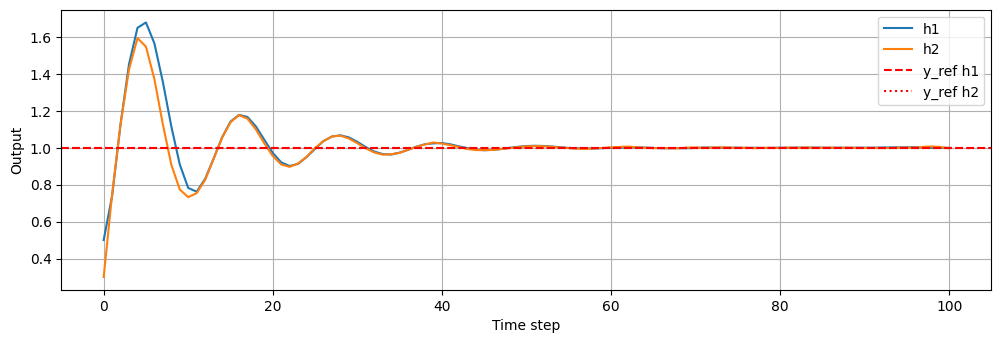

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0], label='h1')
plt.plot(y_sim_descaled[1], label='h2')
plt.axhline(y=scaler.inverse_transform(y_ref.value.reshape(1, -1))[0][0], color='red', linestyle='--', label='y_ref h1')
plt.axhline(y=scaler.inverse_transform(y_ref.value.reshape(1, -1))[0][1], color='red', linestyle=':', label='y_ref h2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

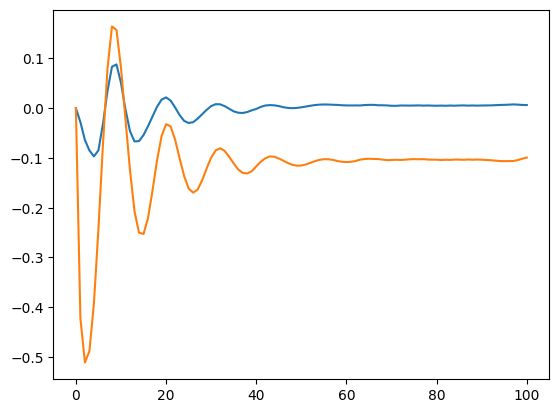

In [ ]:
plt.plot(z_sim[nz:, :].T)

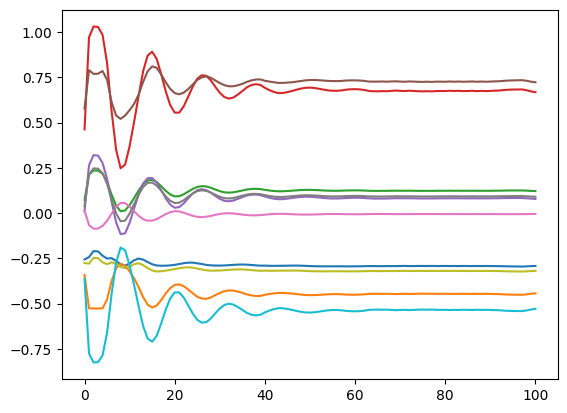

In [ ]:
plt.plot(zs_sim.T, label='h1')

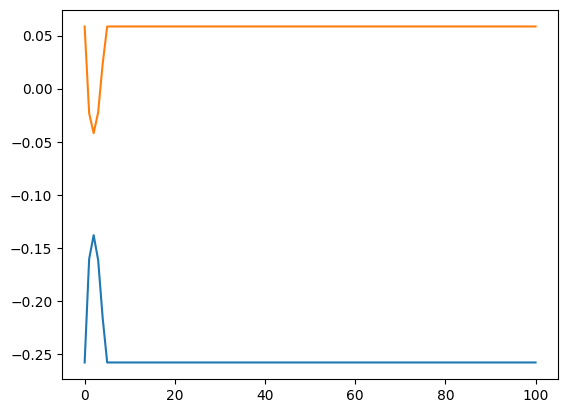

In [ ]:
plt.plot(ys_sim.T)

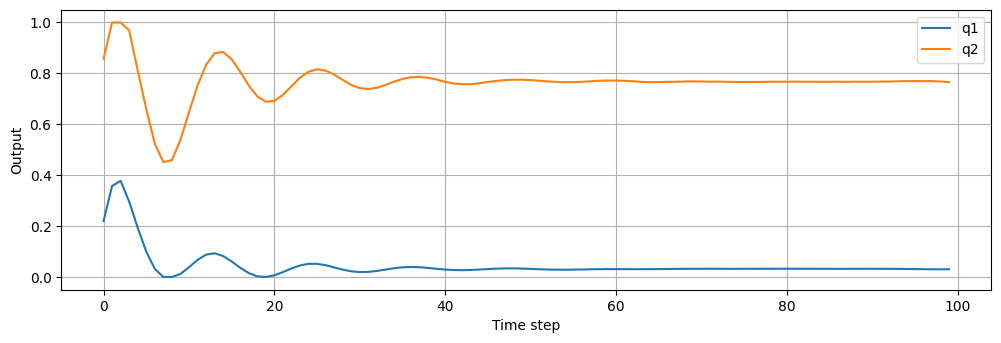

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0], label='q1')
plt.plot(u_sim_descaled[1], label='q2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

## W observer of a disturbance and gradient descent of reference


In [ ]:
# target estimation
z_s = cp.Variable(nz)
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)

# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C @ z_s]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_ref, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimanl value:", target_estimation.value)
print("Optimal u:", u_s.value)
print("Optimal y:", y_s.value)
print("Optimal z:", z_s.value)
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))

y_ref.value = y_s.value
z_ref_store = z_s.value

optimal
Optimanl value: 1.2691291261077066e-18
Optimal u: [-0.97079077  0.63711121]
Optimal y: [-0.25787823  0.05853135]
Optimal z: [-0.25606938 -0.34204551  0.07346435  0.46208751  0.00961057  0.57806848
  0.01480864  0.03828539 -0.27581379 -0.36402591]
Optimal u: [[0.07559511 0.68489824]]
Optimal y: [[1. 1.]]


In [ ]:
z_est = get_x(y_s.value).T[0]
z_s = torch.nn.Parameter(torch.tensor(np.float32(z_ref_store)),requires_grad=True)
optimizer = torch.optim.Adam([z_s], lr=1e-2)
y_sp = torch.tensor(y_s.value, dtype=torch.float32, device=z_s.device)

In [ ]:
# z_s estimation using gradient descent
z_ref = cp.Parameter(nz)
for i in range(100):
    optimizer.zero_grad()
    y_pred = problem.nodes[4]({"x": z_s})["yhat"]
    loss = ((y_pred - y_sp)**2).sum()
    loss.backward()
    optimizer.step()

z_ref.value = z_s.detach().numpy()
#z_ref.value = z_ref_store

In [ ]:
# "enhanced" matrices
F = np.eye(ny)
nd = F.shape[1]

In [ ]:
N = 20
#Jh = helper.evaluate_jacobian(problem.nodes[4], z_s)
Jh = helper.evaluate_jacobian(problem.nodes[4], torch.tensor(z_ref_store))
Qz = Jh.T@np.eye(ny)*20@Jh
#Qz = C.T@np.eye(ny)*20@C
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
Qu = np.eye(nu)

# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
y0 = cp.Parameter(ny)
d0 = cp.Parameter(nd)
u_prev = cp.Parameter(nu)
y_ref = cp.Parameter(ny)
y_sp = cp.Parameter(ny)
z_ref = cp.Parameter(nz)

# Decision variables
z = cp.Variable((nz, N+1))
y = cp.Variable((ny, N))
delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N + 1)) 

In [ ]:

# Constraints and cost
constraints = [z[:, 0] == z0]
constraints += [u[:, 0] == u_prev + delta_u[:, 0]]
cost = 0
for k in range(N):
    constraints += [u[:, k] == u[:, k-1] + delta_u[:, k]]
    
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        y[:, k] == C @ z[:, k] + F @ d0,
        u_min <= u[:, k], u[:, k] <= u_max,
        y_min <= y[:, k], y[:, k] <= y_max
    ]
    
    cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(delta_u[:, k], Qu)

# Terminal cost - not yet
# cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [ ]:
y0.value = scaler.transform(np.array([[0.5 , 0.3]]))[0]
z0.value = get_x(y0.value).T[0]
d0.value = np.zeros(nd)
u_prev.value = scalerU.transform(np.array([[0.1, 0.1]]))[0]
y_ref.value = scaler.transform(np.array([[1, 1]]))[0]
y_sp.value = scaler.transform(np.array([[1, 1]]))[0]
z_ref.value = z_s.detach().numpy()

In [ ]:
z_ref.value


array([-0.23724996, -0.34553623,  0.10430026,  0.4272149 ,  0.04302476,
        0.60349673, -0.00192538,  0.00770223, -0.2461288 , -0.39801872],
      dtype=float32)

In [ ]:
z_est

array([ 0.08075562, -0.07630251,  0.06179626,  0.11521299,  0.04248875,
        0.2145575 , -0.02005869,  0.01279768,  0.02185497, -0.05644025],
      dtype=float32)

In [ ]:
# # z_s estimation using gradient descent
# y_sp = scaler.transform(np.array([[1, 1]]))[0]
# z_est = get_x(y_sp)
# z_s = torch.nn.Parameter(torch.tensor(z_est.T),requires_grad=True)
# optimizer = torch.optim.Adam([z_s], lr=1e-2)
# y_sp = torch.tensor(y_sp, dtype=torch.float32, device=z_s.device)

# for i in range(100):
#     optimizer.zero_grad()
#     y_pred = problem.nodes[4]({"x": z_s})["yhat"]
#     loss = ((y_pred - y_sp)**2).sum()
#     loss.backward()
#     optimizer.step()

# z_ref.value = z_s.detach().numpy()[0]

In [ ]:
z_ref.value

array([-0.23724996, -0.34553623,  0.10430026,  0.4272149 ,  0.04302476,
        0.60349673, -0.00192538,  0.00770223, -0.2461288 , -0.39801872],
      dtype=float32)

In [ ]:
# sanity check
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[0.129876   1.50129207]
optimal


In [ ]:
# # z_s estimation using gradient descent
# y_sp = scaler.transform(np.array([[1, 1]]))[0]
# z_est = get_x(y_sp)
# z_s = torch.nn.Parameter(torch.tensor(z_est.T),requires_grad=True)
# optimizer = torch.optim.Adam([z_s], lr=1e-2)
# y_sp = torch.tensor(y_sp, dtype=torch.float32, device=z_s.device)

# for i in range(100):
#     optimizer.zero_grad()
#     y_pred = problem.nodes[4]({"x": z_s})["yhat"]
#     loss = ((y_pred - y_sp)**2).sum()
#     loss.backward()
#     optimizer.step()

# z_ref.value = z_s.detach().numpy()[0]
# z_ref.value = z_ref_store

In [ ]:
def set_reference():
    z_s = torch.nn.Parameter(torch.tensor(np.float32(z_ref_store)),requires_grad=True)
    optimizer = torch.optim.Adam([z_s], lr=1e-2)
    y_sp = torch.tensor(y_s.value, dtype=torch.float32, device=z_s.device)
    d = torch.tensor(d0.value)
    z_ref = cp.Parameter(nz)
    for i in range(100):
        optimizer.zero_grad()
        y_pred = problem.nodes[4]({"x": z_s})["yhat"]
        loss = ((y_pred + d - y_sp)**2).sum()
        loss.backward()
        optimizer.step()

    z_ref.value = z_s.detach().numpy()

In [ ]:
# Observer initialization

P0 = np.eye(nz+nd) * 0.1 # initial covariance
Q = np.eye(nz+nd) * 0.01  # process noise
R = np.eye(ny) * 0.05  # measurement noise
z0_obs = np.concatenate((z0.value, d0.value))

EKF = helper.EKF_noC(A, B, z0_obs, P0, problem, Q, R, True, F, C)

Simulation

In [ ]:
sim_time = 100
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))
zs_sim = np.zeros((nz, sim_time+1))

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))


z_sim[:, 0] = z0_obs
y_sim[:, 0] = y0.value
ys_sim[:, 0] = y_s.value
zs_sim[:, 0] = z_ref.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y0.value.reshape(1,-1))[0]

#z_ref.value = z_s.value

for k in range(sim_time):
    # solve MPC
    mpc.solve(solver=cp.GUROBI)
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = EKF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    y0.value = y_sim[:, k+1]
    z0.value = z_sim[:nz, k+1]
    d0.value = z_sim[nz:, k+1]
    # new reference
    z_s = torch.nn.Parameter(torch.tensor(np.float32(z_ref_store)),requires_grad=True)
    optimizer = torch.optim.Adam([z_s], lr=1e-2)
    y_sp = torch.tensor(y_s.value, dtype=torch.float32, device=z_s.device)
    d = torch.tensor(d0.value)
    z_ref = cp.Parameter(nz)
    for i in range(100):
        optimizer.zero_grad()
        y_pred = problem.nodes[4]({"x": z_s})["yhat"]
        loss = ((y_pred + d - y_sp)**2).sum()
        loss.backward()
        optimizer.step()

    z_ref.value = z_s.detach().numpy()
    
    zs_sim[:, k+1] = z_ref.value
    u_prev.value = u_sim[:, k]
    print(mpc.status)
    

optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal


In [ ]:
d0.value

array([0.03613861, 0.00732397])

In [ ]:
z_ref.value

array([-0.23143162, -0.36718678,  0.09931362,  0.43715972,  0.03293933,
        0.60328645, -0.00940636,  0.01497001, -0.25120035, -0.38876563],
      dtype=float32)

In [ ]:
z_ref.value

array([-0.23143162, -0.36718678,  0.09931362,  0.43715972,  0.03293933,
        0.60328645, -0.00940636,  0.01497001, -0.25120035, -0.38876563],
      dtype=float32)

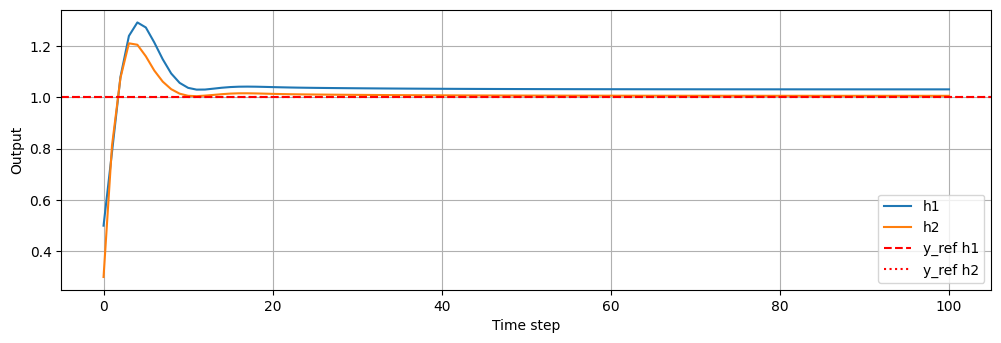

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0], label='h1')
plt.plot(y_sim_descaled[1], label='h2')
plt.axhline(y=scaler.inverse_transform(y_ref.value.reshape(1, -1))[0][0], color='red', linestyle='--', label='y_ref h1')
plt.axhline(y=scaler.inverse_transform(y_ref.value.reshape(1, -1))[0][1], color='red', linestyle=':', label='y_ref h2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

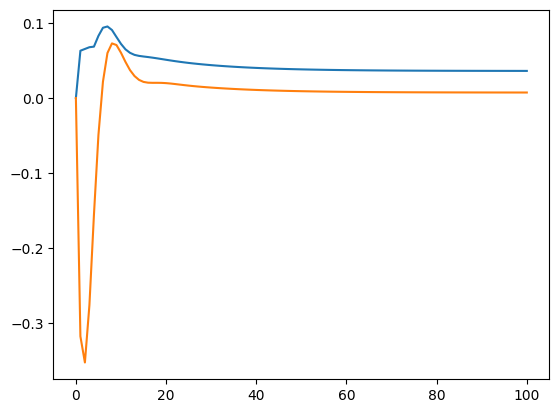

In [ ]:
plt.plot(z_sim[nz:, :].T)

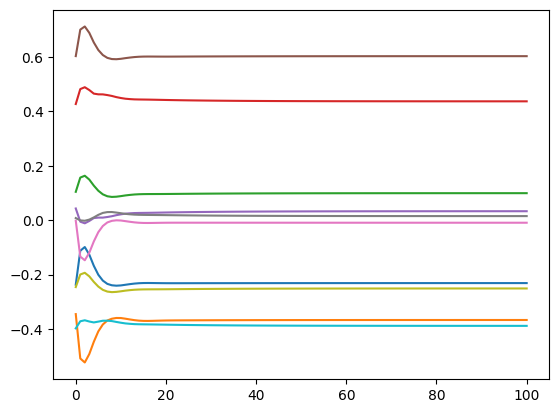

In [ ]:
plt.plot(zs_sim.T, label='h1')

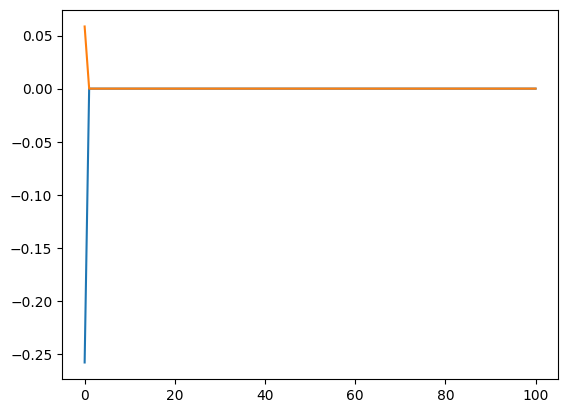

In [ ]:
plt.plot(ys_sim.T)

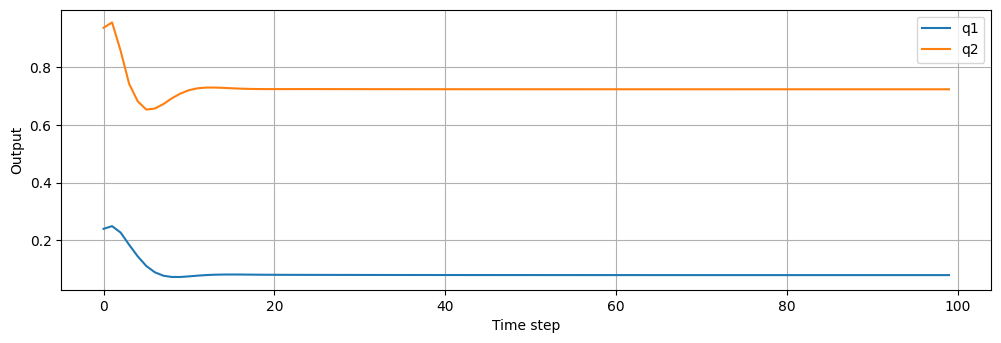

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0], label='q1')
plt.plot(u_sim_descaled[1], label='q2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 